In [627]:
#### import global modules
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from yaml import safe_load
import google.oauth2.credentials
from google.cloud import bigquery
import gc

# Set global vars
pth_project = Path(os.getcwd().split('notebooks')[0])
pth_data = pth_project / 'data'
pth_queries = pth_project / 'core' / 'queries'
pth_creds = pth_project / 'conf' / 'local' / 'project_config.yaml'
sys.path.insert(0, str(pth_project))
d_project_config = safe_load(pth_creds.open())
# d_params = safe_load((pth_project / 'core' / 'parameters' / 'common.yaml').open())['data_extract']

# import local modules
from core.utils.gcp import connect_bq_services
# from core.etl.extract import extract_bq_data, extract_pr_codes, format_conv_df, filter_convs

# Connect to google services
bq_client = connect_bq_services(d_project_config['gcp-project-name'])
pd.options.display.max_rows = 100
from sklearn.model_selection import train_test_split


In [628]:
def extract_bq_data(bq_client, sql=None, pth_query=None):
    if sql is not None:
        df = bq_client.query(sql).to_dataframe()
    elif pth_query is not None:
        sql = pth_query.read_text()
        df = bq_client.query(sql).to_dataframe()
    else:
        raise ValueError('`sql` or `pth_query` should be set')  
    return df

In [629]:
Query= '''

select * from `divgpras-pr-579355.SHS.SHS_churn_model_train_data_sep_nov_2022`

'''

In [630]:
DF=extract_bq_data(bq_client, sql=Query)

In [631]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334134 entries, 0 to 334133
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_id                   334134 non-null  Int64  
 1   dealer_customer_id            334134 non-null  object 
 2   primary_login_id              334134 non-null  Int64  
 3   dealer_name                   334134 non-null  object 
 4   join_date                     334134 non-null  object 
 5   account_type_name             334134 non-null  object 
 6   customer_type_name            334134 non-null  object 
 7   Package                       334134 non-null  object 
 8   Tenure_months                 334134 non-null  Int64  
 9   BAN                           334134 non-null  Int64  
 10  cust_bus_cust_id              334134 non-null  object 
 11  contract_start_date           302317 non-null  object 
 12  contract_end_date             334134 non-nul

In [632]:
# DF.to_csv('SHS_churn_model_train_data_sep_nov_2022.csv',index=False)

In [633]:
DF.isnull().sum() * 100 / len(DF)

customer_id                      0.000000
dealer_customer_id               0.000000
primary_login_id                 0.000000
dealer_name                      0.000000
join_date                        0.000000
account_type_name                0.000000
customer_type_name               0.000000
Package                          0.000000
Tenure_months                    0.000000
BAN                              0.000000
cust_bus_cust_id                 0.000000
contract_start_date              9.522228
contract_end_date                0.000000
contract_end_status              0.000000
Contract_start_months            9.522228
customer_id_1                   17.185620
Best_Practices_1                17.185620
Best_Practices_2                17.185620
Best_Practices_3                17.185620
Best_Practices_4                17.185620
Best_Practices_5                17.185620
Best_Practices_6                17.185620
Best_Practice_All               17.185620
customer_id_2                   57

In [634]:
# DF['Best_Practices_1']=DF['Best_Practices_1'].fillna(0,inplace=True)
# DF['Best_Practices_2']=DF['Best_Practices_2'].fillna(0,inplace=True)
# DF['Best_Practices_3']=DF['Best_Practices_3'].fillna(0,inplace=True)
# DF['Best_Practices_4']=DF['Best_Practices_4'].fillna(0,inplace=True)
# DF['Best_Practices_5']=DF['Best_Practices_5'].fillna(0,inplace=True)
# DF['Best_Practices_6']=DF['Best_Practices_6'].fillna(0,inplace=True)
# DF['Best_Practice_All']=DF['Best_Practice_All'].fillna(0,inplace=True)

In [635]:
DF['Best_Practices_1'].value_counts()

1    246368
0     30343
Name: Best_Practices_1, dtype: Int64

In [651]:
ID_cols=['customer_id','dealer_customer_id','BAN']
ignore_cols=['primary_login_id','dealer_name','join_date','account_type_name','customer_type_name','cust_bus_cust_id'
             ,'contract_start_date','contract_end_date','customer_id_1','customer_id_2','customer_id_3','ban_1','ban_2'
             ,'BAN_3','sum_arm_commands','sum_disarm_commands','number_days_arming_disarming','count_of_dates_arming'
             ,'sum_login_count','number_of_login_days','count_of_dates_login','shs_count','Telus_Cust_ID']

Target_col=['SMHM_Churn']

In [652]:
DF['Avg_SMHM_ARPU']=pd.to_numeric(DF['Avg_SMHM_ARPU'])
DF['Avg_FFH_ARPU']=pd.to_numeric(DF['Avg_FFH_ARPU'])
# DF['Avg_SMHM_ARPU']=pd.to_numeric(DF['Avg_SMHM_ARPU'])


In [653]:
# DF['Best_Practices_1']=DF['Best_Practices_1'].astype('category')
# DF['Best_Practices_2']=DF['Best_Practices_2'].astype('category')
# DF['Best_Practices_3']=DF['Best_Practices_3'].astype('category')
# DF['Best_Practices_4']=DF['Best_Practices_4'].astype('category')
# DF['Best_Practices_5']=DF['Best_Practices_5'].astype('category')
# DF['Best_Practices_6']=DF['Best_Practices_6'].astype('category')
# DF['Best_Practice_All']=DF['Best_Practice_All'].astype('category')
# DF['SMHM_Churn']=DF['SMHM_Churn'].astype('category')



In [654]:

num_cols=DF.select_dtypes(include=np.number).columns.tolist()
cat_cols=DF.select_dtypes(exclude=np.number).columns.tolist()

num_cols_features=list(set(num_cols)-set(ID_cols)-set(Target_col)-set(ignore_cols))
cat_cols_features=list(set(cat_cols)-set(ID_cols)-set(Target_col)-set(ignore_cols))
feature_cols=cat_cols_features+num_cols_features

In [655]:
len(feature_cols)

24

In [656]:
num_cols_features

['ttv_count',
 'Avg_arm_per_day',
 'hsic_count',
 'Best_Practices_3',
 'Best_Practices_5',
 'Tenure_months',
 'Best_Practices_1',
 'Contract_start_months',
 'Avg_FFH_ARPU',
 'Best_Practices_6',
 'Best_Practice_All',
 'Avg_login_per_day',
 'stv_count',
 'Avg_SMHM_ARPU',
 'Best_Practices_2',
 'Best_Practices_4',
 'diic_count',
 'Avg_disarm_per_day',
 'login_consistency',
 'sing_count',
 'arming_consistency',
 'product_mix_all']

In [657]:
cat_cols_features

['contract_end_status', 'Package']

In [658]:
DF[feature_cols].isnull().sum() * 100 / len(DF[feature_cols])

contract_end_status       0.000000
Package                   0.000000
ttv_count                 0.000000
Avg_arm_per_day          57.083984
hsic_count                0.000000
Best_Practices_3         17.185620
Best_Practices_5         17.185620
Tenure_months             0.000000
Best_Practices_1         17.185620
Contract_start_months     9.522228
Avg_FFH_ARPU              0.737129
Best_Practices_6         17.185620
Best_Practice_All        17.185620
Avg_login_per_day        18.875361
stv_count                 0.000000
Avg_SMHM_ARPU             0.796088
Best_Practices_2         17.185620
Best_Practices_4         17.185620
diic_count                0.000000
Avg_disarm_per_day       57.083984
login_consistency        18.875361
sing_count                0.000000
arming_consistency       57.083984
product_mix_all           0.000000
dtype: float64

In [659]:
def impute_missing_values(dataset=DF):
    
    for cols in dataset.columns:
        if dataset[cols].dtype == np.dtype('O'):
            # df.loc[np.isnan(df["Age"]), 'Age'] = rand1
            #dataset.loc[dataset[cols].isnull(), cols]="Missing_category"
            dataset[cols]=dataset[cols].fillna("Missing_category",inplace=False)
        else:
            dataset[cols]=dataset[cols].fillna(0,inplace=False)
            #dataset.loc[dataset[cols].isnull(), cols]=0
    return dataset

 
DF[feature_cols]=impute_missing_values(dataset=DF[feature_cols])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [660]:
DF['SMHM_Churn'].value_counts()

0    330112
1      4022
Name: SMHM_Churn, dtype: Int64

In [661]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334134 entries, 0 to 334133
Data columns (total 50 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   customer_id                   334134 non-null  Int64  
 1   dealer_customer_id            334134 non-null  object 
 2   primary_login_id              334134 non-null  Int64  
 3   dealer_name                   334134 non-null  object 
 4   join_date                     334134 non-null  object 
 5   account_type_name             334134 non-null  object 
 6   customer_type_name            334134 non-null  object 
 7   Package                       334134 non-null  object 
 8   Tenure_months                 334134 non-null  Int64  
 9   BAN                           334134 non-null  Int64  
 10  cust_bus_cust_id              334134 non-null  object 
 11  contract_start_date           302317 non-null  object 
 12  contract_end_date             334134 non-nul

In [662]:
def data_splitting(dataset=DF,feature_cols=[],Target=[],testsize=0.3):
    
    
    X=dataset[feature_cols]
    Y=dataset[Target]
    X1=pd.get_dummies(X,prefix_sep='__')
    X_train, X_validation, Y_train, Y_validation = train_test_split(X1, Y, test_size=testsize, random_state=11,stratify=Y)
    final_feature_columns=X_train.columns.tolist()
    print()
    print("Data splitting Completed.")
    return X_train,X_validation,Y_train,Y_validation,final_feature_columns
# %%
X_train,X_validation,Y_train,Y_validation,final_feature_columns=data_splitting(
dataset=DF,feature_cols=feature_cols,Target=Target_col,testsize=0.3)


Data splitting Completed.


In [663]:
X_train.shape

(233893, 28)

In [664]:
import json

with open('Final_feature_columns.json', 'w') as Ffp:
    json.dump(final_feature_columns, Ffp)


with open('Intial_feature_columns.json', 'w') as Ifp:
    json.dump(feature_cols, Ifp)

In [665]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer

def Capture_Rate_1stSD(ground_truth, prediction):
    """ this functions takes in the model
    test features, targets, will return the
    lift dataframe
    """
    #print("data shape:", ground_truth.shape)

    prediction_df = pd.DataFrame(prediction, columns=["prob_of_predict_1"])
    # print(prediction_df.head())
    y_df = pd.DataFrame(ground_truth, columns=['target'])
    prediction_with_label_df = y_df.join(prediction_df.set_index(y_df.index))
    # Calculate lift on validation data
    v1 = prediction_with_label_df[['target', 'prob_of_predict_1']]
    v1.sort_values(by=['prob_of_predict_1'], inplace=True)
    v1['Qcut'] = pd.qcut(v1['prob_of_predict_1'].rank(
    method='first'), q=20, labels=False)
    v1['SD'] = 20-(v1['Qcut'].astype(int))
    vl1 = v1.drop(['Qcut'], axis=1)
    vl1['Freq'] = vl1.groupby('SD')['target'].transform(np.sum)
    vl2 = vl1.drop(['target', 'prob_of_predict_1'], axis=1).drop_duplicates()
    vl2.sort_values(by=['SD'], inplace=True)
    vl2['Cumm Sum'] = vl2['Freq'].cumsum()
    vl2['Lift'] = vl2['Freq'].div(vl2['Freq'].sum(), axis=0).div(0.05)
    vl2['Cumm Lift'] = vl2['Cumm Sum'].div(
    vl2['Freq'].sum(), axis=0).div(vl2['SD']/20)
    vl2['Capture Rate'] = vl2['Lift']*5
    #vl2['Capture Rate_defintion'] = vl2['Freq']/vl2.iloc[19, 'Cumm Sum']
    vl2['Cummu Capture Rate'] = vl2['Capture Rate'].cumsum()

    # this is lift csv
    # vl2.to_csv("/lift_chart_{0}.csv".format(today))
    # vl2.to_csv(
    # f'lift_of_{model}_on_{datetime.today().strftime("%Y-%m-%d")}.csv')
    # print(f'lift_of_{model}_on_{datetime.today().strftime("%Y-%m-%d")}.csv')
    #print("Training process completed success")
    Magic_score= round(vl2.iloc[0, 6],2)
    print("Cumm Capture Rate on 1st SD is: ", Magic_score)
    #vl2[vl2['SD'] == 1, 'Lift'].iloc[0]
    return Magic_score



def lift_calc_pd(model, X_test, y_test,target_column): # , model_path
    """ this functions takes in the model
    test features, targets, will return the
    lift dataframe
    """
    prediction = model.predict_proba(X_test)
    print("output shape", prediction.shape)
    print("y_test shape:", y_test.shape)
    #Total_Actual_positive_targets=sum(y_test[target_column])
    #print('Total_Actual_positive_targets:',Total_Actual_positive_targets)


    prediction_df = pd.DataFrame(
    prediction, columns=['prob_of_predict_0', 'prob_of_predict_1'])
    y_df = pd.DataFrame(y_test, columns=[target_column])
    prediction_with_label_df = y_df.join(prediction_df.set_index(y_df.index))


    # Calculate lift on validation data
    v1 = prediction_with_label_df[[target_column, 'prob_of_predict_1']]
    v1.sort_values(by=['prob_of_predict_1'], inplace=True)
    v1['Qcut'] = pd.qcut(v1['prob_of_predict_1'].rank(
    method='first'), q=20, labels=False)
    v1['SD'] = 20-(v1['Qcut'].astype(int))


    vl1 = v1.drop(['Qcut'], axis=1)
    vl1['Freq'] = vl1.groupby('SD')[target_column].transform(np.sum)
    vl2 = vl1.drop([target_column, 'prob_of_predict_1'], axis=1).drop_duplicates()
    vl2.sort_values(by=['SD'], inplace=True)
    vl2['Cumm Sum'] = vl2['Freq'].cumsum()
    vl2['Lift'] = vl2['Freq'].div(vl2['Freq'].sum(), axis=0).div(0.05)
    vl2['Cumm Lift'] = vl2['Cumm Sum'].div(vl2['Freq'].sum(), axis=0).div(vl2['SD']/20)
    vl2['Capture Rate'] = vl2['Lift']*5
    vl2['Cummu Capture Rate'] = vl2['Capture Rate'].cumsum()
    # vl2['Capture_Rate_Defintion']= vl2['Freq']*100/Total_Actual_positive_targets
    # vl2['Cummu_Capture_Rate_Defintion']= vl2['Capture_Rate_Defintion'].cumsum()
    return pd.DataFrame(vl2)


In [666]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [667]:
Algo= 'XGB_SMHM'
#Optimization='TuneCV_BOHB_6thSD_Lift'
Optimization='RandomSearch_CaptureRate'

custom_scorer = make_scorer(
    Capture_Rate_1stSD, greater_is_better=True, needs_proba=True)

In [668]:
params = {
    "gamma": list(range(1, 21)),
    "subsample": np.round(np.arange(0.2, 1, 0.1),2).tolist(),
    "colsample_bytree": np.round(np.arange(0.2, 1, 0.1),2).tolist(),
    "n_estimators": np.arange(10, 200, 10).tolist(), 
    "max_depth": list(range(3, 7)),
    # "scale_pos_weight": list(range(1, 20)),
    "learning_rate": np.round(np.arange(0.001, 0.3, 0.005),3).tolist()
}

In [669]:
params_1 = {
    "n_estimators": [10,20]
}

In [670]:
xgb = XGBClassifier(
    #learning_rate=0.02,
    #n_estimators=50,
    # objective="binary:logistic",
    nthread=-1,
    verbosity=1,
    use_label_encoder=False
    # enable_categorical=True
    # tree_method="gpu_hist"  # this enables GPU.
    # See https://github.com/dmlc/xgboost/issues/2819
)

In [671]:
Y_train.value_counts()

SMHM_Churn
0             231078
1               2815
dtype: int64

In [672]:
# Y_train=Y_train.astype('category')

In [673]:
Y_train.isnull().sum()

SMHM_Churn    0
dtype: int64

In [674]:
Y_train.dtypes

SMHM_Churn    Int64
dtype: object

In [675]:
search = RandomizedSearchCV(xgb, param_distributions=params_1,cv=3,error_score="raise")

In [676]:
search_1=GridSearchCV(estimator=xgb,param_grid=params_1,scoring=custom_scorer)

In [677]:
Y_train.values

array([[0],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]], dtype=object)

In [678]:
# search_1.fit(X_train,Y_train.values)

In [679]:
xgb.fit(X_train,Y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [680]:
# search_1.best_params_

In [681]:
# pd.DataFrame(search_1.cv_results_)

In [682]:
val_DF_metric=lift_calc_pd(model=xgb,X_test=X_validation
,y_test=Y_validation,target_column=Target_col[0])

output shape (100241, 2)
y_test shape: (100241, 1)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [683]:
val_DF_metric

,SD,Freq,Cumm Sum,Lift,Cumm Lift,Capture Rate,Cummu Capture Rate
107565,1,421,421,6.975973,6.975973,34.879867,34.879867
149028,2,153,574,2.535211,4.755592,12.676056,47.555924
285782,3,82,656,1.358741,3.623308,6.793703,54.349627
285554,4,80,736,1.325601,3.048882,6.628003,60.97763
3278,5,65,801,1.077051,2.654515,5.385253,66.362883
139550,6,62,863,1.027341,2.38332,5.136703,71.499586
77469,7,42,905,0.69594,2.142265,3.479702,74.979287
190817,8,38,943,0.62966,1.95319,3.148302,78.127589
310214,9,38,981,0.62966,1.806131,3.148302,81.275891
217498,10,33,1014,0.54681,1.680199,2.734051,84.009942


<AxesSubplot:>

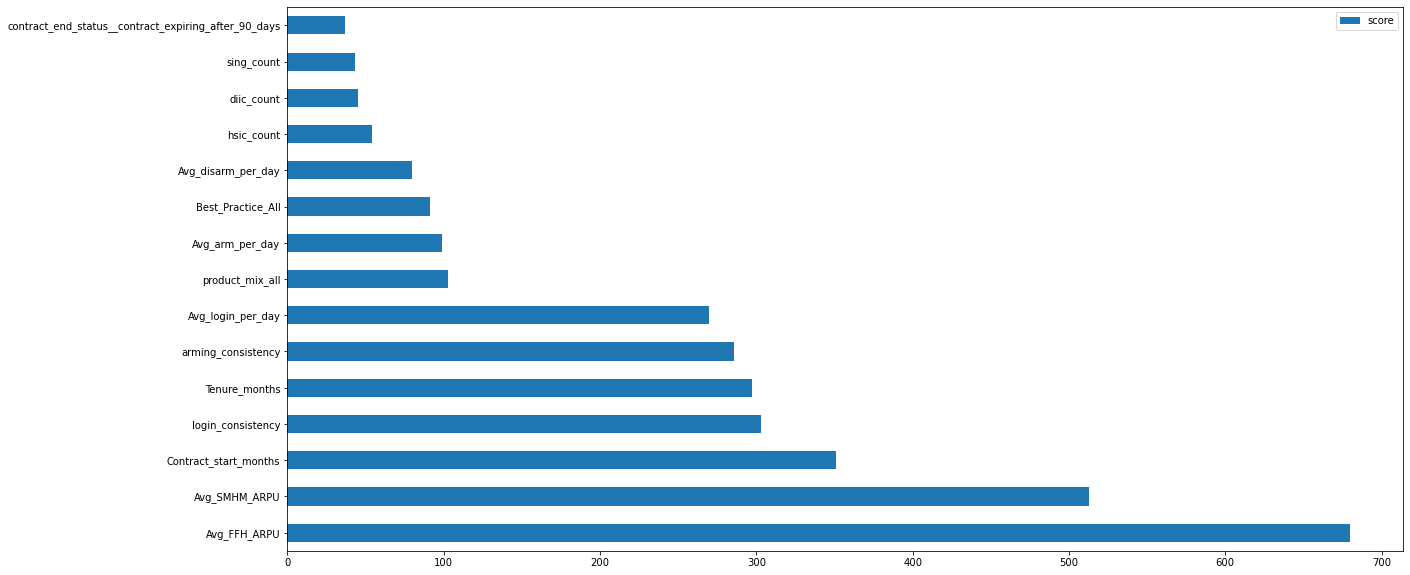

In [684]:
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(15, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


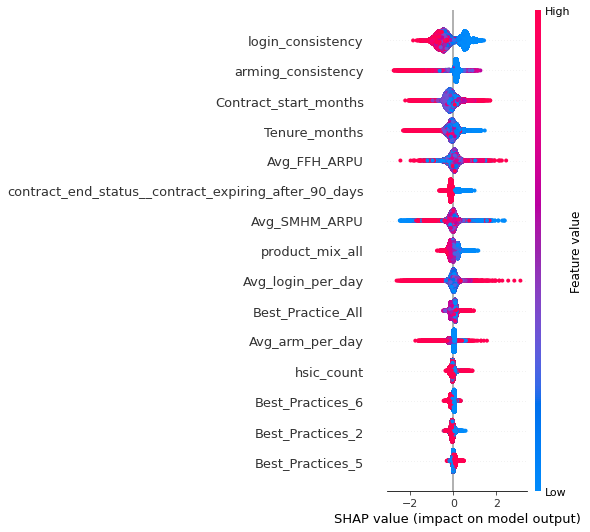

In [685]:
import shap
# model_shap = XGB_final_model.best_estimator_
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train,check_additivity=False)
#%%

shap.summary_plot(shap_values, features=X_train
, feature_names=final_feature_columns,show=False,max_display=15)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


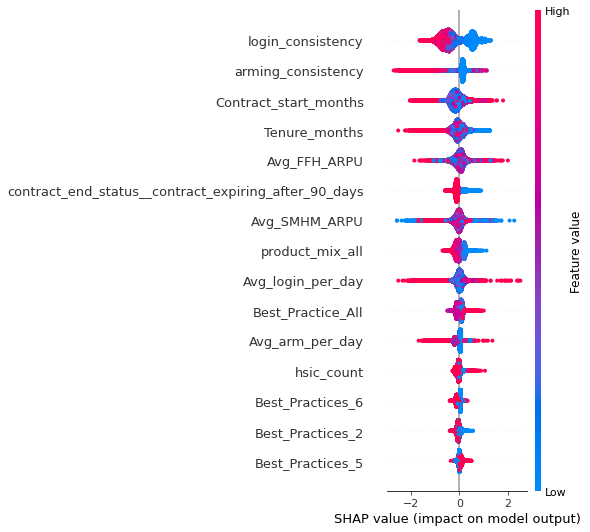

In [687]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_validation,check_additivity=False)
#%%

shap.summary_plot(shap_values, features=X_validation
, feature_names=final_feature_columns,show=False,max_display=15)

In [361]:
# Y_train=Y_train.astype('int')
# Y_validation=Y_validation.astype('int')

In [689]:
import datetime
import joblib

date_time_now=datetime.datetime.now().strftime("%Y%m%d_%I%M%S")
Model_filename_1=Algo+'_'+'SMHM_churn_model'+'_'+date_time_now+'.pkl'
joblib.dump(xgb,Model_filename_1)


['XGB_SMHM_SMHM_churn_model_20230317_065805.pkl']

In [362]:
# X_train=X_train.astype('int')
# X_validation=X_validation.astype('int')

In [686]:
X_train.dtypes

ttv_count                                                  Int64
Avg_arm_per_day                                          float64
hsic_count                                                 Int64
Best_Practices_3                                           Int64
Best_Practices_5                                           Int64
Tenure_months                                              Int64
Best_Practices_1                                           Int64
Contract_start_months                                      Int64
Avg_FFH_ARPU                                             float64
Best_Practices_6                                           Int64
Best_Practice_All                                          Int64
Avg_login_per_day                                        float64
stv_count                                                  Int64
Avg_SMHM_ARPU                                            float64
Best_Practices_2                                           Int64
Best_Practices_4         

In [381]:
Y_train=Y_train.astype('float64')
Y_validation=Y_validation.astype('float64')

In [382]:
X_train['ttv_count']=X_train['ttv_count'].astype('float64')
X_train['sing_count']=X_train['sing_count'].astype('float64')
X_train['hsic_count']=X_train['hsic_count'].astype('float64')
X_train['product_mix_all']=X_train['product_mix_all'].astype('float64')
X_train['diic_count']=X_train['diic_count'].astype('float64')
X_train['stv_count']=X_train['stv_count'].astype('float64')

In [383]:
X_validation['ttv_count']=X_validation['ttv_count'].astype('float64')
X_validation['sing_count']=X_validation['sing_count'].astype('float64')
X_validation['hsic_count']=X_validation['hsic_count'].astype('float64')
X_validation['product_mix_all']=X_validation['product_mix_all'].astype('float64')
X_validation['diic_count']=X_validation['diic_count'].astype('float64')
X_validation['stv_count']=X_validation['stv_count'].astype('float64')

In [459]:
Y_train.dtypes

SMHM_Churn    Int64
dtype: object

In [460]:
Y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180420 entries, 243252 to 187630
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   SMHM_Churn  180420 non-null  Int64
dtypes: Int64(1)
memory usage: 2.9 MB


In [463]:
Y_train.head()

,SMHM_Churn
243252,0
178901,0
149461,0
115511,0
58339,0


In [480]:
# Y_train_1=Y_train['SMHM_Churn'].astype('int').to_list()
# Y_validation_1=Y_validation['SMHM_Churn'].astype('int').to_list()

In [502]:
# Y_train_1 = Y_train['SMHM_Churn'].astype('int')
# Y_validation_1 = Y_validation['SMHM_Churn'].astype('int')

In [540]:
Y_train_1=np.squeeze(Y_train['SMHM_Churn'].values)
Y_validation_1 = np.squeeze(Y_validation['SMHM_Churn'].values)

In [541]:
# X_train['ttv_count']=X_train['ttv_count'].to_list()
# X_train['sing_count']=X_train['sing_count'].to_list()
# X_train['hsic_count']=X_train['hsic_count'].to_list()
# X_train['product_mix_all']=X_train['product_mix_all'].to_list()
# X_train['diic_count']=X_train['diic_count'].to_list()
# X_train['stv_count']=X_train['stv_count'].to_list()

In [542]:
# X_validation['ttv_count']=X_validation['ttv_count'].to_list()
# X_validation['sing_count']=X_validation['sing_count'].to_list()
# X_validation['hsic_count']=X_validation['hsic_count'].to_list()
# X_validation['product_mix_all']=X_validation['product_mix_all'].to_list()
# X_validation['diic_count']=X_validation['diic_count'].to_list()
# X_validation['stv_count']=X_validation['stv_count'].to_list()

In [543]:
X_train.reset_index(drop=True,inplace=True)
X_validation.reset_index(drop=True,inplace=True)
# X_test.reset_index(drop=True,inplace=True)

In [544]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(
                        n_jobs=-1,
                        n_estimators=100000,
                        learning_rate=0.01,
                        num_leaves=64,
                        num_threads=4,
                        max_depth=-1,
                        tree_learner='serial',
                        feature_fraction=0.7,
                        bagging_freq=5,
                        bagging_fraction=0.7,
                        verbose=-1,
                        bagging_seed=11
                    )


model_lgb.fit(X_train, Y_train_1, early_stopping_rounds=200, eval_set=[(X_train,Y_train_1),(X_validation, Y_validation_1)],eval_metric=custom_scorer,verbose=500)

ValueError: Unknown label type: 'unknown'

In [499]:
Y_train.values.flatten()

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [501]:
Y_train['SMHM_Churn'].unique()

<IntegerArray>
[0, 1]
Length: 2, dtype: Int64